In [1]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from scipy.optimize import curve_fit
import plotly.graph_objs as go
import plotly.offline as pyo



## Import the 2 datasets and join them as one file. 

In [2]:
# Load each dataset
df1 = pd.read_excel('D:\Case Study\LR1865SZ_cycles201214_002_4.xlsx')
df2 = pd.read_excel('D:\Case Study\LR1865SZ_cycles201217_001_2.xlsx')


In [3]:
#Inspect their features and types
print("Dataset 1 columns:", df1.columns.tolist())
print(df1.dtypes, end="\n\n")

print("Dataset 2 columns:", df2.columns.tolist())
print(df2.dtypes, end="\n\n")

Dataset 1 columns: ['Data_Point', 'Test_Time(s)', 'Current(A)', 'Capacity(Ah)', 'Voltage(V)', 'Energy(Wh)', 'Temperature(℃)', 'Date_Time', 'Cycle_Index']
Data_Point                 int64
Test_Time(s)              object
Current(A)               float64
Capacity(Ah)             float64
Voltage(V)               float64
Energy(Wh)               float64
Temperature(℃)            object
Date_Time         datetime64[ns]
Cycle_Index                int64
dtype: object

Dataset 2 columns: ['Data_Point', 'Test_Time(s)', 'Current(A)', 'Capacity(Ah)', 'Voltage(V)', 'Energy(Wh)', 'Temperature(℃)', 'Date_Time', 'Cycle_Index']
Data_Point                 int64
Test_Time(s)              object
Current(A)               float64
Capacity(Ah)             float64
Voltage(V)               float64
Energy(Wh)               float64
Temperature(℃)            object
Date_Time         datetime64[ns]
Cycle_Index                int64
dtype: object



In [4]:
df1

,Data_Point,Test_Time(s),Current(A),Capacity(Ah),Voltage(V),Energy(Wh),Temperature(℃),Date_Time,Cycle_Index
0,1,00:00:00,0.0,0.000,4.1902,0.000,-,2020-12-14 10:16:16,1
1,2,00:00:01,0.0,0.000,4.1902,0.000,-,2020-12-14 10:16:18,1
2,3,00:00:02,0.0,0.000,4.1893,0.000,-,2020-12-14 10:16:19,1
3,4,00:00:04,0.0,0.000,4.1905,0.000,-,2020-12-14 10:16:20,1
4,5,00:00:05,0.0,0.000,4.1902,0.000,-,2020-12-14 10:16:21,1
...,...,...,...,...,...,...,...,...,...
202511,202512,2-08:39:24,0.0,0.451,3.7872,1.838,-,2020-12-16 18:55:40,101
202512,202513,2-08:39:25,0.0,0.451,3.7872,1.838,-,2020-12-16 18:55:41,101
202513,202514,2-08:39:26,0.0,0.451,3.7872,1.838,-,2020-12-16 18:55:42,101
202514,202515,2-08:39:27,0.0,0.451,3.7912,1.838,-,2020-12-16 18:55:43,101


In [5]:
df2

,Data_Point,Test_Time(s),Current(A),Capacity(Ah),Voltage(V),Energy(Wh),Temperature(℃),Date_Time,Cycle_Index
0,1,00:00:00,0.0,0.000,4.1859,0.000,-,2020-12-17 09:45:59,1
1,2,00:00:02,0.0,0.000,4.1859,0.000,-,2020-12-17 09:46:01,1
2,3,00:00:03,0.0,0.000,4.1859,0.000,-,2020-12-17 09:46:02,1
3,4,00:00:04,0.0,0.000,4.1859,0.000,-,2020-12-17 09:46:03,1
4,5,00:00:05,0.0,0.000,4.1859,0.000,-,2020-12-17 09:46:04,1
...,...,...,...,...,...,...,...,...,...
126643,126644,1-11:19:45,0.0,0.268,3.7643,1.098,-,2020-12-18 21:05:44,101
126644,126645,1-11:19:45,0.0,0.268,3.7655,1.098,-,2020-12-18 21:05:45,101
126645,126646,1-11:19:47,0.0,0.268,3.7649,1.098,-,2020-12-18 21:05:46,101
126646,126647,1-11:19:48,0.0,0.268,3.7643,1.098,-,2020-12-18 21:05:47,101


In [6]:
# Tag it as different cell
df1['source'] = 'Test cell 1'
df2['source'] = 'Test cell 2'

In [7]:
#Stack both the cells
df_all = pd.concat([df1, df2], ignore_index=True)

# Test conditions

print(df_all.groupby('source')['Current(A)'].agg(['min','max']))
print(df_all.groupby('source')['Cycle_Index'].max())

               min    max
source                   
Test cell 1 -4.808  4.808
Test cell 2 -7.207  7.207
source
Test cell 1    101
Test cell 2    101
Name: Cycle_Index, dtype: int64


Here df_all contains the combined data for both cells with a source column showing cell 1 vs cell 2. Here both the cells have 101 cycles. The test cell 1 was cycled at ~4.8 A at cell capacity 2.3 Ah and test cell 2 was cycled at ~7.2 A at cell capacity 2.3 Ah which will indicate us to compare performance at two different C-rates.

## Analysing voltage, time, current, capacity, energy and cycle_Index 

##  Data Cleaning

In [8]:
# Turn the original column into strings
times = df_all['Test_Time(s)'].astype(str)

# Insert days for any “D-HH:MM:SS” patterns
times = times.str.replace(r'^(\d+)-', r'\1 days ', regex=True)

# Parse into a Timedelta series
td = pd.to_timedelta(times, errors='coerce')

# Extract total seconds into a new column
df_all['Time_s'] = td.dt.total_seconds()

#Now check for NaN or infinite in the numeric column
n_nans = df_all['Time_s'].isna().sum()
n_infs = np.isinf(df_all['Time_s']).sum()

print(f"NaNs in Time_s: {n_nans}")
print(f"Infinite values in Time_s: {n_infs}")


NaNs in Time_s: 0
Infinite values in Time_s: 0


Converted Test_Time(s) values including multi-day spans into a single numeric seconds column which is  Time_s.

In [9]:
 # Drop the Temperature column (not needed)
 df_all.drop(columns=['Temperature(℃)'], inplace=True)

The Temperature(℃) column only contained a placeholder "- " and no data.Its is missing. So i dropped it.And its mentioned in data set that temperature is 25

In [10]:
df_all


,Data_Point,Test_Time(s),Current(A),Capacity(Ah),Voltage(V),Energy(Wh),Date_Time,Cycle_Index,source,Time_s
0,1,00:00:00,0.0,0.000,4.1902,0.000,2020-12-14 10:16:16,1,Test cell 1,0.0
1,2,00:00:01,0.0,0.000,4.1902,0.000,2020-12-14 10:16:18,1,Test cell 1,1.0
2,3,00:00:02,0.0,0.000,4.1893,0.000,2020-12-14 10:16:19,1,Test cell 1,2.0
3,4,00:00:04,0.0,0.000,4.1905,0.000,2020-12-14 10:16:20,1,Test cell 1,4.0
4,5,00:00:05,0.0,0.000,4.1902,0.000,2020-12-14 10:16:21,1,Test cell 1,5.0
...,...,...,...,...,...,...,...,...,...,...
329159,126644,1-11:19:45,0.0,0.268,3.7643,1.098,2020-12-18 21:05:44,101,Test cell 2,127185.0
329160,126645,1-11:19:45,0.0,0.268,3.7655,1.098,2020-12-18 21:05:45,101,Test cell 2,127185.0
329161,126646,1-11:19:47,0.0,0.268,3.7649,1.098,2020-12-18 21:05:46,101,Test cell 2,127187.0
329162,126647,1-11:19:48,0.0,0.268,3.7643,1.098,2020-12-18 21:05:47,101,Test cell 2,127188.0


In [11]:
#Count nulls per column
null_counts = df_all.isna().sum()

#Count infinite values per numeric column
inf_counts = df_all.select_dtypes(include=[np.number]) \
                   .apply(lambda col: np.isinf(col).sum())

#Combine into a single table
missing = pd.DataFrame({
    'nulls': null_counts,
    'infs':  inf_counts
})

print(missing)


              nulls  infs
Capacity(Ah)      0   0.0
Current(A)        0   0.0
Cycle_Index       0   0.0
Data_Point        0   0.0
Date_Time         0   NaN
Energy(Wh)        0   0.0
Test_Time(s)      0   NaN
Time_s            0   0.0
Voltage(V)        0   0.0
source            0   NaN


Checking for missing values. And missing values is 0 for all considered column. The infs column shows NaN for Date_Time, Test_Time(s) and source since its numeric dtypes there.

##   exploratory data analysis



Descriptive stats for Test cell 1 


,Voltage(V),Current(A),Capacity(Ah),Energy(Wh)
count,202516.000000,202516.000000,202516.000000,202516.000000
mean,3.729247,-0.018207,0.671768,2.523373
std,0.305172,4.012437,0.436089,1.650002
min,2.999400,-4.808000,0.000000,0.000000
25%,3.492400,-4.807000,0.339000,1.269000
50%,3.754700,0.000000,0.590000,2.206000
75%,3.998000,4.807000,0.957000,3.590000
max,4.200500,4.808000,2.264000,8.111000


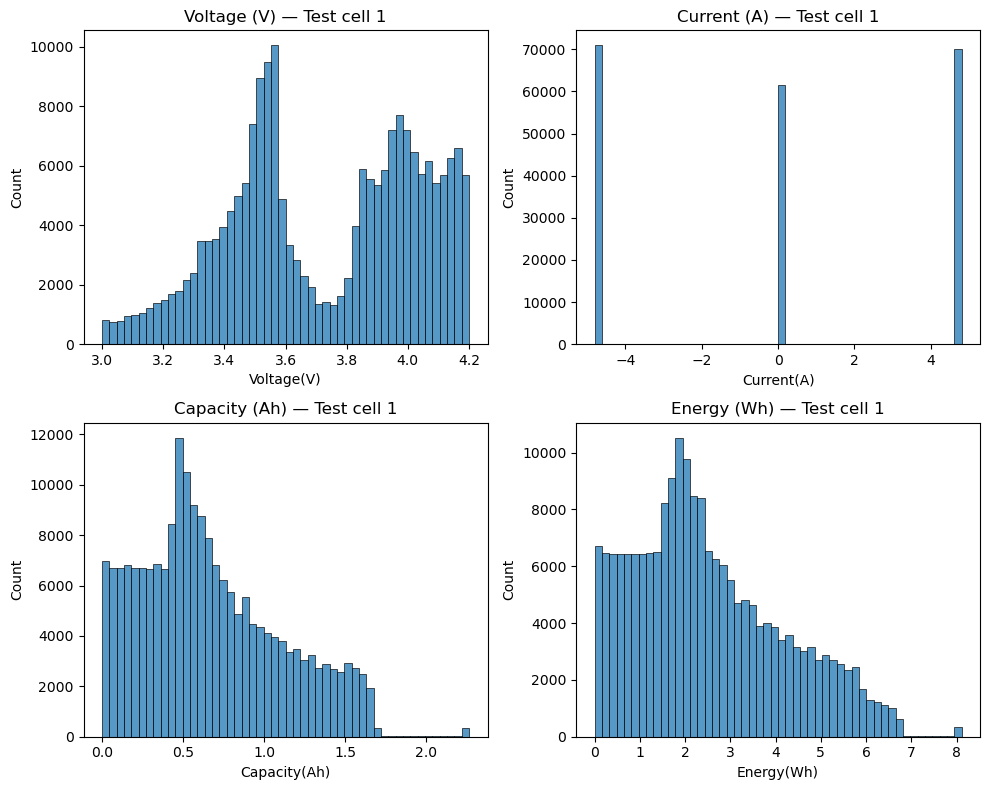



Descriptive stats for Test cell 2 


,Voltage(V),Current(A),Capacity(Ah),Energy(Wh)
count,126648.000000,126648.000000,126648.000000,126648.000000
mean,3.701336,-0.042464,0.530199,1.972970
std,0.296801,5.158074,0.368905,1.383366
min,2.999400,-7.207000,0.000000,0.000000
25%,3.480300,-7.194000,0.286000,1.036000
50%,3.764300,0.000000,0.426000,1.585000
75%,3.927000,7.194000,0.726000,2.702000
max,4.200800,7.207000,2.271000,7.963000


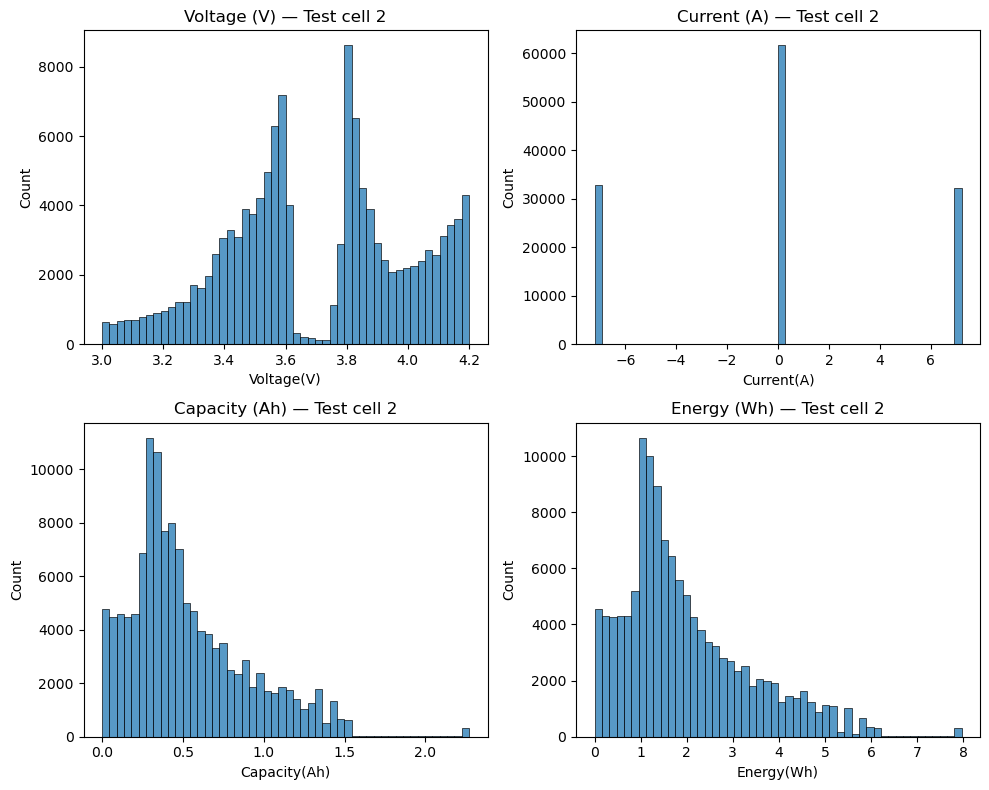

In [12]:
# Descriptive stats and histograms for Test Cell 1 and 2
vars_  = ['Voltage(V)', 'Current(A)', 'Capacity(Ah)', 'Energy(Wh)']
titles = ["Voltage (V)", "Current (A)", "Capacity (Ah)", "Energy (Wh)"]

for src in df_all['source'].unique():
    sub = df_all[df_all['source']==src]
    print(f"\n\nDescriptive stats for {src} ")
    display(sub[vars_].describe())
    
    # plot histograms
    fig, axes = plt.subplots(2,2, figsize=(10,8))
    for ax, var, title in zip(axes.ravel(), vars_, titles):
        sns.histplot(sub[var], bins=50, ax=ax)
        ax.set_title(f"{title} — {src}")
    plt.tight_layout()
    plt.show()


 Voltage is about 2.9 V (minimum during discharge) to 4.2 V (maximum charge voltage). The current is mostly constant ±4.8 A
 for cell 1 and ±7.2 A for cell 2 for active charge/discharge. It has 0 A during rest. This is can be learnt from a histogram of current which is tri-modal: a peak near the positive constant current, a peak near the negative constant current, and a spike at 0 A (rest periods). The capacity (Ah) column in each cycle typically starts at 0 and increases during a charge or discharge step. The energy (Wh) similarly starts at 0 and increases; its range and distribution closely correlate with capacity since energy =  (Voltage * Capacity). The cycle index from 1 to 101,

The capacity values recorded at the end of each cycle decrease over time which indicates degradation which can see in capacity vs cycle plots below

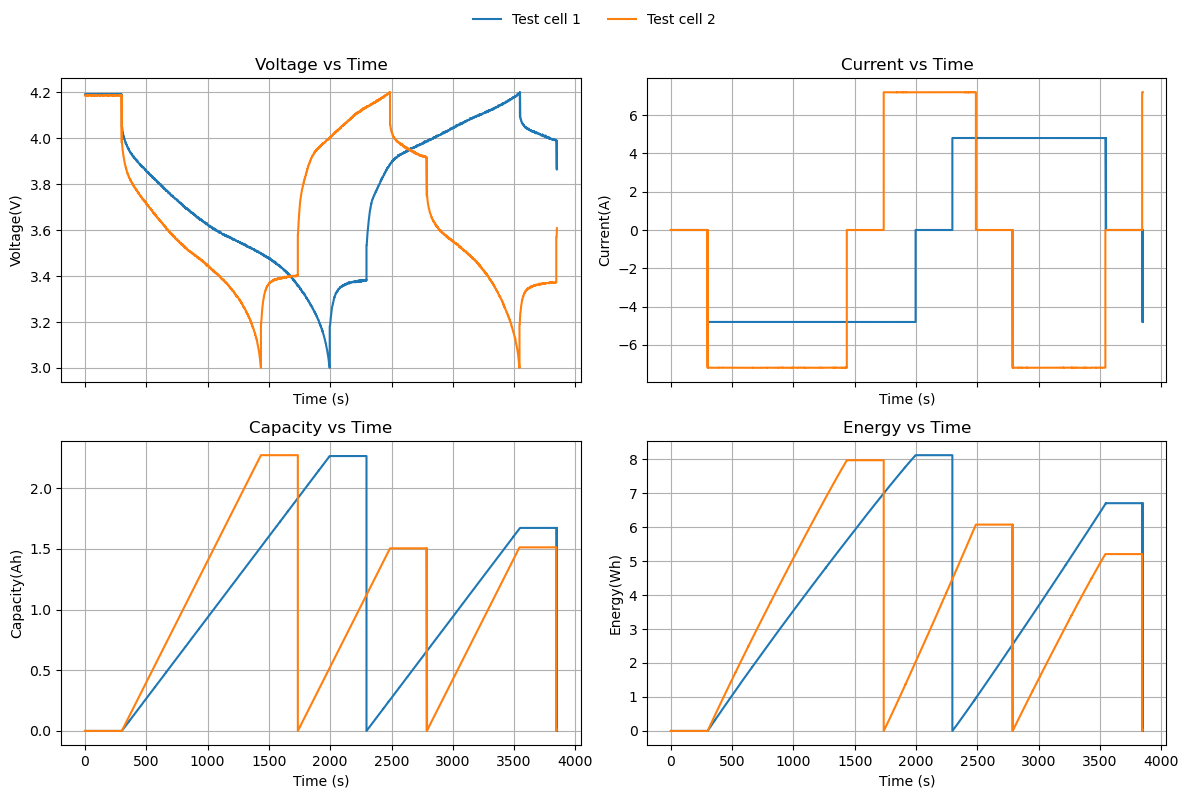

In [13]:
# Trim till the second cycle
df_trim = df_all[df_all['Time_s'] <= 3850]

# Define metrics and titles
metrics = ['Voltage(V)', 'Current(A)', 'Capacity(Ah)', 'Energy(Wh)']
titles  = ['Voltage vs Time', 'Current vs Time', 'Capacity vs Time', 'Energy vs Time']

# Create 2×2 axes
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
axes = axes.flatten()

# Plot each metric
for ax, metric, title in zip(axes, metrics, titles):
    for src in df_trim['source'].unique():
        sub = df_trim[df_trim['source'] == src].sort_values('Time_s')
        ax.plot(sub['Time_s'], sub[metric], label=src)
    ax.set_title(title)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel(metric)
    ax.grid(True)

# Put one legend at the top of the figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2, frameon=False)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:

# Initialize Plotly’s notebook 
pyo.init_notebook_mode(connected=True)

# Subset to Test cell 1
sub = df_all[df_all['source']=='Test cell 1'].sort_values('Time_s')

# Build the WebGL trace
fig = go.Figure(
    go.Scattergl(
        x=sub['Time_s'],
        y=sub['Voltage(V)'],
        mode='lines',
        line=dict(color='blue', width=2),
        hoverinfo='none'
    )
)

# Label your axes
fig.update_layout(
    title="Voltage Profile (Test cell 1, WebGL)",
    xaxis_title="Time (s)",
    yaxis_title="Voltage (V)",
    template="plotly_white"
)

# Display
pyo.iplot(fig)


# Subset to Test cell 2
sub = df_all[df_all['source']=='Test cell 2'].sort_values('Time_s')

# Build the WebGL trace
fig = go.Figure(
    go.Scattergl(
        x=sub['Time_s'],
        y=sub['Voltage(V)'],
        mode='lines',
        line=dict(color='blue', width=2),
        hoverinfo='none'
    )
)

# Label your axes
fig.update_layout(
    title="Voltage Profile (Test cell 2, WebGL)",
    xaxis_title="Time (s)",
    yaxis_title="Voltage (V)",
    template="plotly_white"
)

# Display
pyo.iplot(fig)


From both WebGL it was understandable that, if we go from left to the right side of that plot, the peak voltage plateau falls slightly downward over the cycles. And The trough of end-of-discharge voltage goes upward a bit. The horizontal width of each sawtooth that means the times per cycle slowly reduces. Its shows the capacity fade. That means less Ah to charge/discharge gives shorter cycle time.

In [ ]:
#Subset to Test cell 1
sub = df_all[df_all['source']=='Test cell 1'].sort_values('Time_s')

# Build the WebGL trace
fig = go.Figure(
    go.Scattergl(
        x=sub['Time_s'],
        y=sub['Current(A)'],
        mode='lines',
        line=dict(color='blue', width=2),
        hoverinfo='none'
    )
)

# Label your axes
fig.update_layout(
    title="Current Profile (Test cell 1, WebGL)",
    xaxis_title="Time (s)",
    yaxis_title="Current(A)",
    template="plotly_white"
)

# Display
pyo.iplot(fig)

# Subset to Test cell 1
sub = df_all[df_all['source']=='Test cell 2'].sort_values('Time_s')

# Build the WebGL trace
fig = go.Figure(
    go.Scattergl(
        x=sub['Time_s'],
        y=sub['Current(A)'],
        mode='lines',
        line=dict(color='blue', width=2),
        hoverinfo='none'
    )
)

# Label your axes
fig.update_layout(
    title="Current Profile (Test cell 2, WebGL)",
    xaxis_title="Time (s)",
    yaxis_title="Current(A)",
    template="plotly_white"
)

# Display
pyo.iplot(fig)

Its CC–CV cycling protocol. At the start of cycle that means left, all pulses have nearly identical width. It meaning each cycle took the same amount of time. From left to right, the width  plateaus gradually reduce, shows the capacity fade as seen in voltage sawtooth.

In [ ]:
# Subset to Test cell 1
sub = df_all[df_all['source']=='Test cell 1'].sort_values('Time_s')

# Build the WebGL trace
fig = go.Figure(
    go.Scattergl(
        x=sub['Time_s'],
        y=sub['Capacity(Ah)'],
        mode='lines',
        line=dict(color='blue', width=2),
        hoverinfo='none'
    )
)

# Label your axes
fig.update_layout(
    title="Capacity(Ah) (Test cell 1, WebGL)",
    xaxis_title="Time (s)",
    yaxis_title="Capacity(Ah)",
    template="plotly_white"
)

# Display
pyo.iplot(fig)


# Subset to Test cell 2
sub = df_all[df_all['source']=='Test cell 2'].sort_values('Time_s')

# Build the WebGL trace
fig = go.Figure(
    go.Scattergl(
        x=sub['Time_s'],
        y=sub['Capacity(Ah)'],
        mode='lines',
        line=dict(color='blue', width=2),
        hoverinfo='none'
    )
)

# Label your axes
fig.update_layout(
    title="Capacity(Ah) (Test cell 2, WebGL)",
    xaxis_title="Time (s)",
    yaxis_title="Capacity(Ah)",
    template="plotly_white"
)

# Display
pyo.iplot(fig)



The peak of each capacity vs time reduce if we go right. Early in life each cycle reaches ∼2.1 Ah capacity; by the end it’s down somewhat (0.3–0.5 Ah) for both the cell.So capacity is fading monotonically and the two cells behave differently because of its different C-rates.



In [14]:
df_all

,Data_Point,Test_Time(s),Current(A),Capacity(Ah),Voltage(V),Energy(Wh),Date_Time,Cycle_Index,source,Time_s
0,1,00:00:00,0.0,0.000,4.1902,0.000,2020-12-14 10:16:16,1,Test cell 1,0.0
1,2,00:00:01,0.0,0.000,4.1902,0.000,2020-12-14 10:16:18,1,Test cell 1,1.0
2,3,00:00:02,0.0,0.000,4.1893,0.000,2020-12-14 10:16:19,1,Test cell 1,2.0
3,4,00:00:04,0.0,0.000,4.1905,0.000,2020-12-14 10:16:20,1,Test cell 1,4.0
4,5,00:00:05,0.0,0.000,4.1902,0.000,2020-12-14 10:16:21,1,Test cell 1,5.0
...,...,...,...,...,...,...,...,...,...,...
329159,126644,1-11:19:45,0.0,0.268,3.7643,1.098,2020-12-18 21:05:44,101,Test cell 2,127185.0
329160,126645,1-11:19:45,0.0,0.268,3.7655,1.098,2020-12-18 21:05:45,101,Test cell 2,127185.0
329161,126646,1-11:19:47,0.0,0.268,3.7649,1.098,2020-12-18 21:05:46,101,Test cell 2,127187.0
329162,126647,1-11:19:48,0.0,0.268,3.7643,1.098,2020-12-18 21:05:47,101,Test cell 2,127188.0


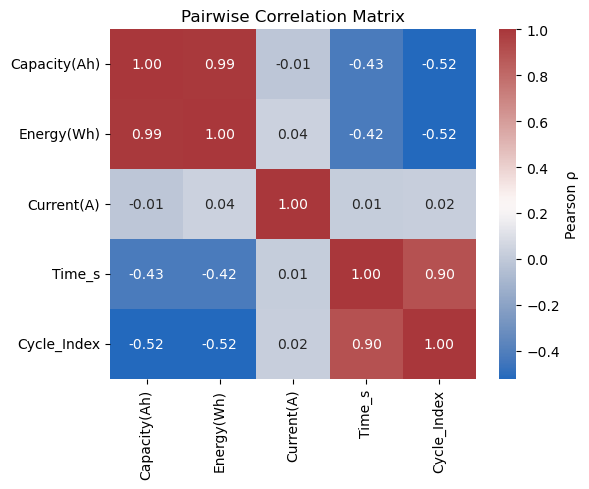

Capacity vs Energy:      0.991863377011251
Capacity vs Current:     -0.013311692606922351
Cycle_Index vs Time_s:   0.9027973522288024


In [15]:

# Needed variables
vars_of_interest = ['Capacity(Ah)', 'Energy(Wh)', 'Current(A)', 'Time_s', 'Cycle_Index']

#compute the pairwise correlation matrix
corr = df_all[vars_of_interest].corr()

# Plotting heatmap
plt.figure(figsize=(6,5))
sns.heatmap(
    corr, 
    annot=True, 
    fmt=".2f", 
    cmap="vlag", 
    cbar_kws={'label': 'Pearson ρ'}
)
plt.title("Pairwise Correlation Matrix")
plt.tight_layout()
plt.show()

# Scalar values:
print("Capacity vs Energy:     ", corr.loc['Capacity(Ah)','Energy(Wh)'])
print("Capacity vs Current:    ", corr.loc['Capacity(Ah)','Current(A)'])
print("Cycle_Index vs Time_s:  ", corr.loc['Cycle_Index','Time_s'])


The energy vs capacity shows a linear relationship (Voltage * Capacity). A quick correlation analysis shows that capacity and energy are highly correlated that also tell higher capacity delivered means more energy. Current and capacity have little overall correlation across the whole dataset. It is because current is mostly constant in each phase, and capacity resets every cycle. Time is strongly correlated with cycle index because each cycle takes a few seconds and total test time grows with cycle count.

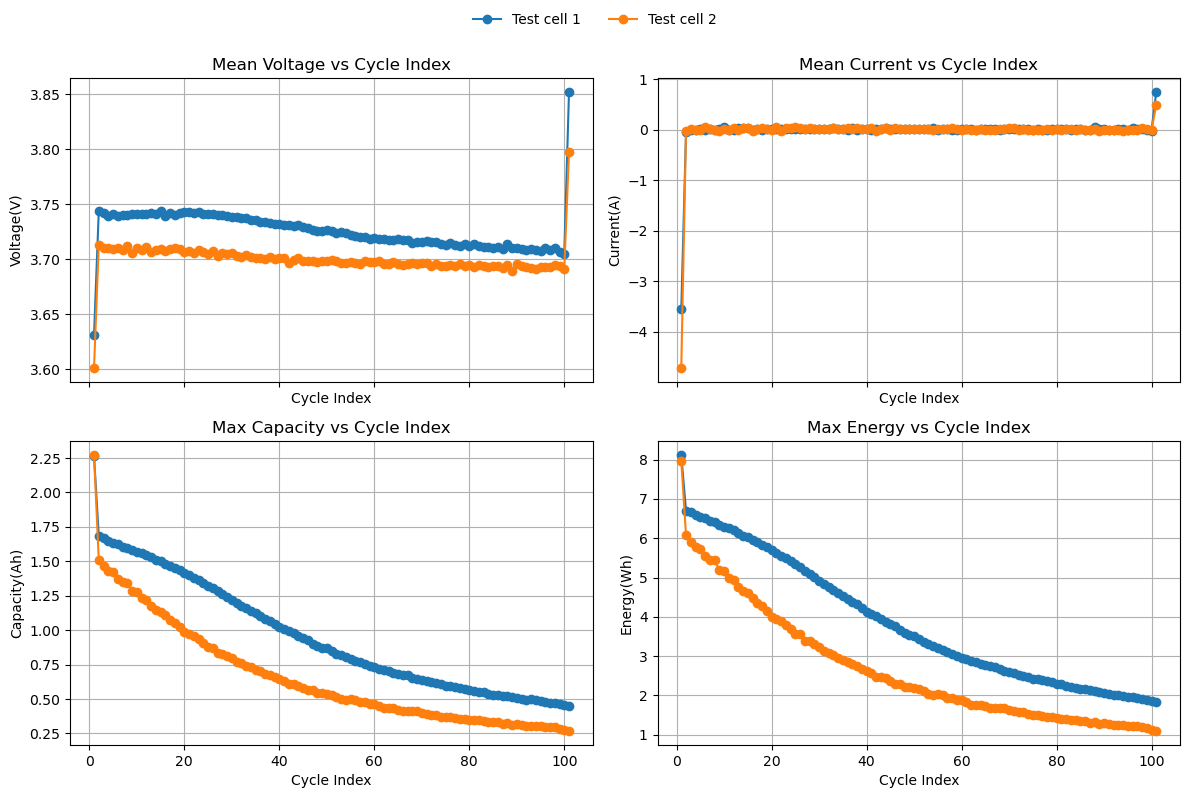

In [16]:
# To compute per-cycle statistics
stat_funcs = {
    'Voltage(V)': 'mean',
    'Current(A)': 'mean',
    'Capacity(Ah)': 'max',
    'Energy(Wh)': 'max'
}

# Compute per-cycle summary
per_cycle_all = (
    df_all
    .groupby(['source', 'Cycle_Index'])
    .agg(stat_funcs)
    .reset_index()
)

# 2x2 subplot visualization
metrics = ['Voltage(V)', 'Current(A)', 'Capacity(Ah)', 'Energy(Wh)']
titles  = ['Mean Voltage', 'Mean Current', 'Max Capacity', 'Max Energy']

fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
axes = axes.flatten()

for ax, metric, title in zip(axes, metrics, titles):
    for src in per_cycle_all['source'].unique():
        sub = per_cycle_all[per_cycle_all['source'] == src]
        ax.plot(sub['Cycle_Index'], sub[metric], marker='o', label=src)
    ax.set_title(f'{title} vs Cycle Index')
    ax.set_xlabel('Cycle Index')
    ax.set_ylabel(metric)
    ax.grid(True)

# Common legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=len(labels), frameon=False)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In cycle 1 it may starts mid-cycle or with a partial charge/discharge. From the data Cycle 1 it has only discharge. Including it  may effect baseline capacity calculation. Similiarly to the last cycle. So i remmoved it.


In [17]:
# Identify the first and last cycle numbers
first_cycle = df_all['Cycle_Index'].min()
last_cycle  = df_all['Cycle_Index'].max()

# Filter them out
df_all = df_all[~df_all['Cycle_Index'].isin([first_cycle, last_cycle])].copy()


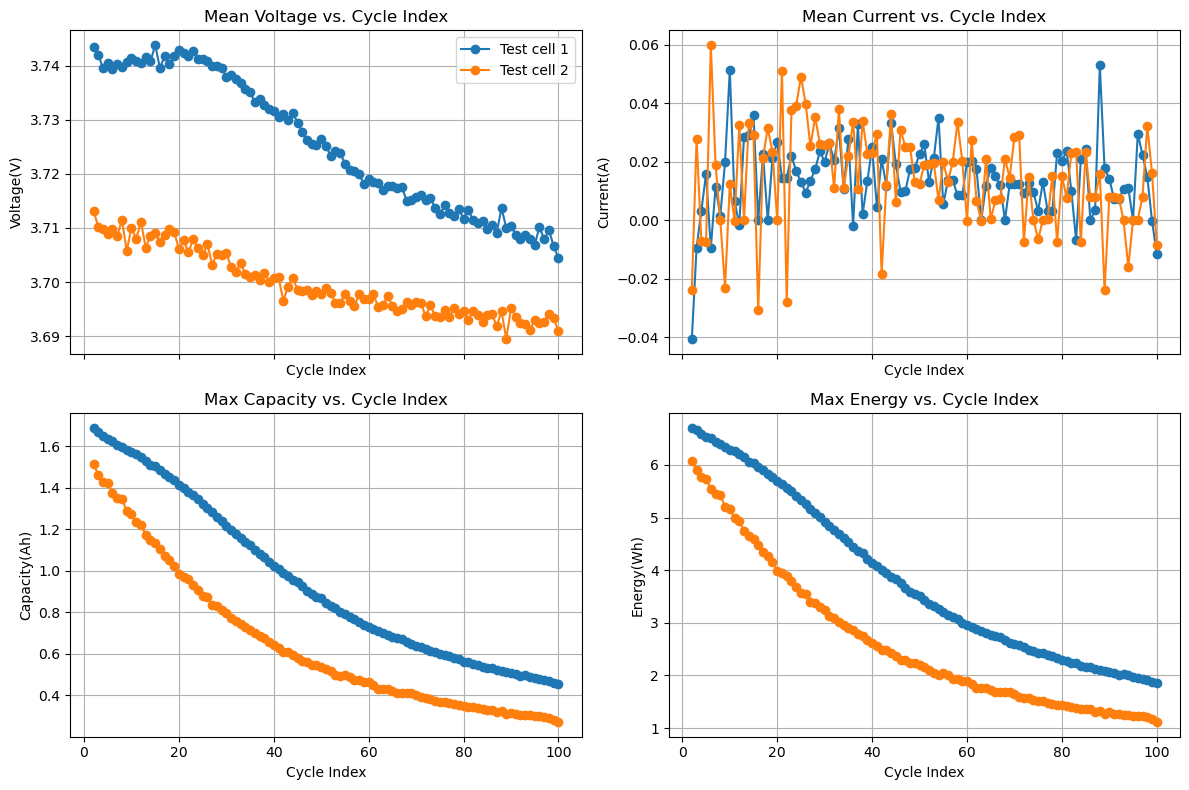

In [18]:
# per‐cycle summaries
stat_funcs = {
    'Voltage(V)':  'mean',
    'Current(A)':  'mean',
    'Capacity(Ah)': 'max',
    'Energy(Wh)':  'max',
}

per_cycle_all = (
    df_all
      .groupby(['source','Cycle_Index'])
      .agg(stat_funcs)
      .reset_index()
)

# metrics and subplot grid
metrics = ['Voltage(V)', 'Current(A)', 'Capacity(Ah)', 'Energy(Wh)']
titles  = ['Mean Voltage', 'Mean Current', 'Max Capacity', 'Max Energy']

fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
axes = axes.flatten()

# Loop over each metric & axis
for ax, metric, title in zip(axes, metrics, titles):
    for src in per_cycle_all['source'].unique():
        sub = per_cycle_all[per_cycle_all['source'] == src]
        ax.plot(
            sub['Cycle_Index'],
            sub[metric],
            marker='o',
            label=src
        )
    ax.set_title(f"{title} vs. Cycle Index")
    ax.set_xlabel("Cycle Index")
    ax.set_ylabel(metric)
    ax.grid(True)

# legend & layout
axes[0].legend(loc='upper right')
plt.tight_layout()
plt.show()


These characteristics can be used to calculate batteries’ ultimate beneficial life (RUL). 

## Charge and Discharge Phase 

In [19]:
# Add a Phase column to label each row for charge and discharge
df_all['Phase'] = df_all['Current(A)'].apply(
    lambda i: 'Charge'    if i >  0 else
              ('Discharge' if i < 0 else 'Idle')
)

In [20]:
df_all

,Data_Point,Test_Time(s),Current(A),Capacity(Ah),Voltage(V),Energy(Wh),Date_Time,Cycle_Index,source,Time_s,Phase
2258,2259,00:38:16,4.807,0.000,3.5352,0.000,2020-12-14 10:54:32,2,Test cell 1,2296.0,Charge
2259,2260,00:38:18,4.807,0.003,3.5352,0.010,2020-12-14 10:54:34,2,Test cell 1,2298.0,Charge
2260,2261,00:38:19,4.807,0.004,3.5476,0.014,2020-12-14 10:54:35,2,Test cell 1,2299.0,Charge
2261,2262,00:38:20,4.807,0.005,3.5572,0.019,2020-12-14 10:54:36,2,Test cell 1,2300.0,Charge
2262,2263,00:38:21,4.805,0.007,3.5612,0.024,2020-12-14 10:54:37,2,Test cell 1,2301.0,Charge
...,...,...,...,...,...,...,...,...,...,...,...
327229,124714,1-10:47:31,0.000,0.269,3.6229,0.881,2020-12-18 20:33:30,100,Test cell 2,125251.0,Idle
327230,124715,1-10:47:32,0.000,0.269,3.6248,0.881,2020-12-18 20:33:31,100,Test cell 2,125252.0,Idle
327231,124716,1-10:47:33,0.000,0.269,3.6254,0.881,2020-12-18 20:33:32,100,Test cell 2,125253.0,Idle
327232,124717,1-10:47:34,0.000,0.269,3.6232,0.881,2020-12-18 20:33:33,100,Test cell 2,125254.0,Idle


This classifies each data point as charge, discharge, or idle. By grouping by cycle index, the sequence of phases in each cycle. From Cycle 2, each cycle contains a full charge step followed by a full discharge step (and some rest periods at the transitions). This entire charge–discharge sequence as one cycle (Cycle_Index increment per full cycle). For example, in cycle 2 of cell 1, the first ~1200 seconds have +4.807 A (charge), then a rest (0 A), then ~1250 seconds of –4.807 A (discharge), then rest. Similarly, cell 2’s cycles have +7.2 A and –7.2 A segments. We will use this phase information to calculate charge/discharge capacities per cycle.

## Capacity Calculation

In [21]:
# Normalizing the phase column once before loop
df_all["Phase"] = df_all["Phase"].str.lower()

# nominal capacity and calculate C-rate
nominal_capacity = 2.3
df_all["C-rate"] = df_all["Current(A)"] / nominal_capacity

# Calculate delta time per cycle using 'Time_s'
df_all["delta_time"] = df_all.groupby(["source", "Cycle_Index"])["Time_s"].diff().fillna(0)

# Calculate incremental capacity dQ in Ah
df_all["dQ"] = df_all["Current(A)"] * df_all["delta_time"] / 3600

# Compute charge and discharge capacity per cycle
cycle_data = []
for (source, cycle), group in df_all.groupby(["source", "Cycle_Index"]):
    charge_capacity = group.loc[group["Phase"] == "charge", "dQ"].sum()
    discharge_capacity = -group.loc[group["Phase"] == "discharge", "dQ"].sum()
    cycle_data.append({
        "source": source,
        "Cycle_Index": cycle,
        "charge_capacity_Ah": charge_capacity,
        "discharge_capacity_Ah": discharge_capacity
    })

df_cycle = pd.DataFrame(cycle_data)


In [22]:
df_cycle

,source,Cycle_Index,charge_capacity_Ah,discharge_capacity_Ah
0,Test cell 1,2,1.671730,1.687753
1,Test cell 1,3,1.666396,1.662351
2,Test cell 1,4,1.646321,1.643640
3,Test cell 1,5,1.634261,1.627651
4,Test cell 1,6,1.624945,1.620943
...,...,...,...,...
193,Test cell 2,96,0.297879,0.297836
194,Test cell 2,97,0.297898,0.295891
195,Test cell 2,98,0.291881,0.289883
196,Test cell 2,99,0.283899,0.281919


This is  coulomb counting, summing the charge transferred over time to get capacity. We apply this integration separately for charge and discharge segments in each cycle (so that charge capacity and discharge capacity are computed independently).
For Test cell 1, charge/discharge capacities decrease to ~1.67 Ah downwards. For Test cell 2, same happens when it reach to lower cycles. Discharge capacity is slightly less than charge. This is expected due to coulombic inefficiency.

In [23]:
df_cycle["coulombic_efficiency_percent"] = (
    df_cycle["discharge_capacity_Ah"] / df_cycle["charge_capacity_Ah"]
) * 100

In [24]:
df_cycle

,source,Cycle_Index,charge_capacity_Ah,discharge_capacity_Ah,coulombic_efficiency_percent
0,Test cell 1,2,1.671730,1.687753,100.958471
1,Test cell 1,3,1.666396,1.662351,99.757227
2,Test cell 1,4,1.646321,1.643640,99.837162
3,Test cell 1,5,1.634261,1.627651,99.595570
4,Test cell 1,6,1.624945,1.620943,99.753684
...,...,...,...,...,...
193,Test cell 2,96,0.297879,0.297836,99.985359
194,Test cell 2,97,0.297898,0.295891,99.326391
195,Test cell 2,98,0.291881,0.289883,99.315550
196,Test cell 2,99,0.283899,0.281919,99.302569


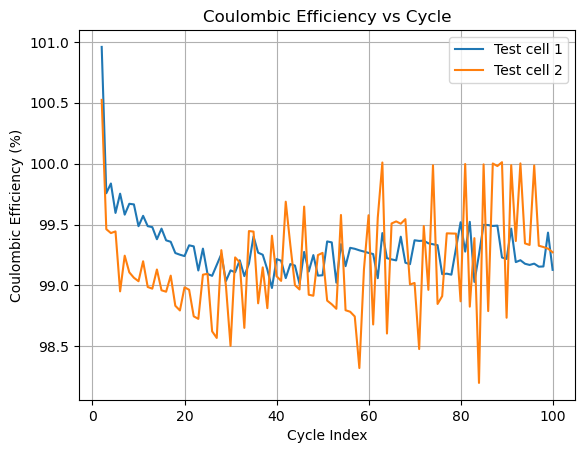

In [25]:
for source in df_cycle["source"].unique():
    subset = df_cycle[df_cycle["source"] == source]
    plt.plot(subset["Cycle_Index"], subset["coulombic_efficiency_percent"], label=source)

plt.xlabel("Cycle Index")
plt.ylabel("Coulombic Efficiency (%)")
plt.title("Coulombic Efficiency vs Cycle")
plt.legend()
plt.grid(True)
plt.show()

Test cell 1 (blue) starts above 101% in early cycles and get stable around 99.2–99.5%. Test cell 2 starts near 100.5%, then shows more fluctuation.Test cell 1 is more stable may be due to lower C-rate. Test cell 2 degrades faster, and CE fluctuation supports this.

## C-rate

In [26]:
df_all

,Data_Point,Test_Time(s),Current(A),Capacity(Ah),Voltage(V),Energy(Wh),Date_Time,Cycle_Index,source,Time_s,Phase,C-rate,delta_time,dQ
2258,2259,00:38:16,4.807,0.000,3.5352,0.000,2020-12-14 10:54:32,2,Test cell 1,2296.0,charge,2.09000,0.0,0.000000
2259,2260,00:38:18,4.807,0.003,3.5352,0.010,2020-12-14 10:54:34,2,Test cell 1,2298.0,charge,2.09000,2.0,0.002671
2260,2261,00:38:19,4.807,0.004,3.5476,0.014,2020-12-14 10:54:35,2,Test cell 1,2299.0,charge,2.09000,1.0,0.001335
2261,2262,00:38:20,4.807,0.005,3.5572,0.019,2020-12-14 10:54:36,2,Test cell 1,2300.0,charge,2.09000,1.0,0.001335
2262,2263,00:38:21,4.805,0.007,3.5612,0.024,2020-12-14 10:54:37,2,Test cell 1,2301.0,charge,2.08913,1.0,0.001335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327229,124714,1-10:47:31,0.000,0.269,3.6229,0.881,2020-12-18 20:33:30,100,Test cell 2,125251.0,idle,0.00000,1.0,0.000000
327230,124715,1-10:47:32,0.000,0.269,3.6248,0.881,2020-12-18 20:33:31,100,Test cell 2,125252.0,idle,0.00000,1.0,0.000000
327231,124716,1-10:47:33,0.000,0.269,3.6254,0.881,2020-12-18 20:33:32,100,Test cell 2,125253.0,idle,0.00000,1.0,0.000000
327232,124717,1-10:47:34,0.000,0.269,3.6232,0.881,2020-12-18 20:33:33,100,Test cell 2,125254.0,idle,0.00000,1.0,0.000000


In [27]:
cell1_current = df_all[df_all["source"] == "Test cell 1"]["Current(A)"].abs().mode()[0]
cell2_current = df_all[df_all["source"] == "Test cell 2"]["Current(A)"].abs().mode()[0]
c_rate_cell1 = round(cell1_current / 2.3, 2) 
c_rate_cell2 = round(cell2_current / 2.3, 2) 
avg_cap_cell1 = df_cycle[df_cycle["source"] == "Test cell 1"]["discharge_capacity_Ah"].mean()
avg_cap_cell2 = df_cycle[df_cycle["source"] == "Test cell 2"]["discharge_capacity_Ah"].mean()


In [28]:
avg_cap_cell1

0.9416662850729517

In [29]:
avg_cap_cell2

0.6444357575757576

Using the nominal capacity of 2.3 Ah, the calculated C-rate for Test Cell 1 is ~2.09 C, based on a dominant cycling current of 4.807 A, while Test Cell 2 operated at a higher C-rate of approximately 3.13 C with a current of 7.2 A. From the processed cycle data, the average discharge capacity observed for Cell 1 was 0.94 Ah, whereas Cell 2 delivered a significantly lower 0.64 Ah on average.This helps to interpret results that. Higher C-rate puts more stress on the battery. it shows that a higher C rate will produce a lower capacity reading.This may be due to increased internal losses at faster discharge.

### Voltage–Capacity Profiles

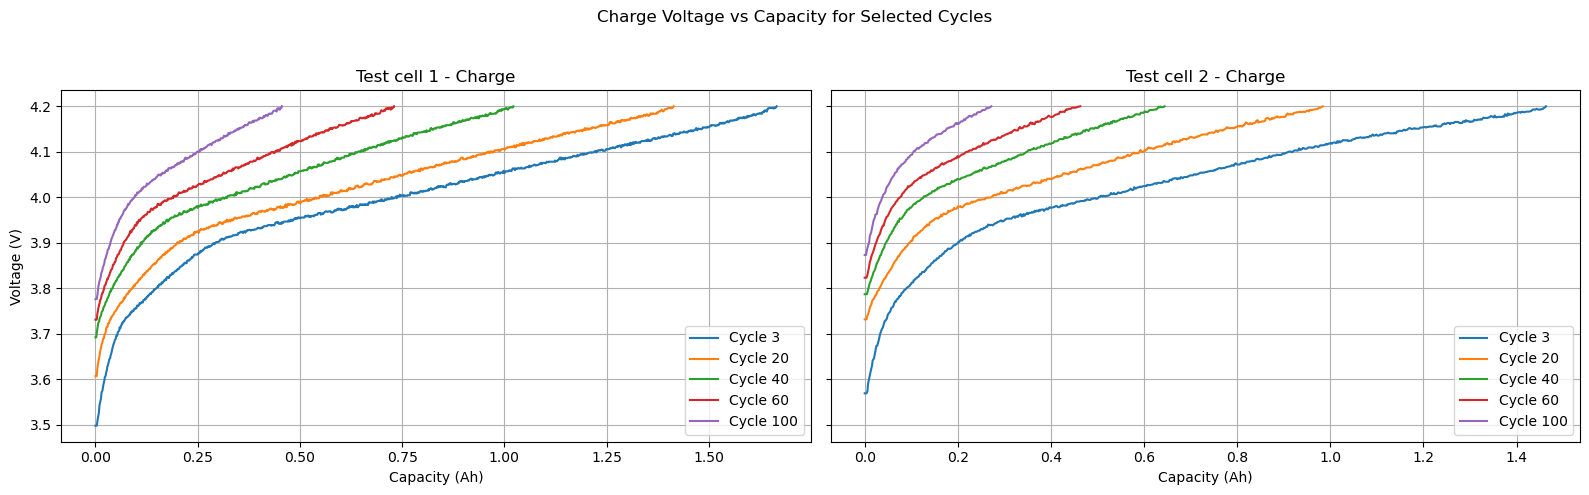

In [30]:
# Necessary cycles and phase
selected_cycles = [3, 20, 40, 60, 100]
phase = "charge"

# Create subplots in a single row (2 cells side-by-side)
fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

# Ensure phase to lowercase for consistent comparison
df_all["Phase"] = df_all["Phase"].str.lower()

# Loop through both test cells and plot
for ax, cell in zip(axes, df_all["source"].unique()):
    for cycle in selected_cycles:
        # Filter data
        mask = (
            (df_all["source"] == cell) &
            (df_all["Cycle_Index"] == cycle) &
            (df_all["Phase"] == phase)
        )
        data = df_all[mask]

        if not data.empty:
            ax.plot(data["Capacity(Ah)"], data["Voltage(V)"], label=f"Cycle {cycle}")

    ax.set_title(f"{cell} - Charge")
    ax.set_xlabel("Capacity (Ah)")
    ax.grid(True)
    ax.legend()

axes[0].set_ylabel("Voltage (V)")
plt.suptitle("Charge Voltage vs Capacity for Selected Cycles")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

A voltage increase in the beginning especially from 3.5 V to ~3.75 V as the cell moves off the flat plateau, then a more gradual rise. Notably, Cell 2’s curve is above Cell 1’s curve. The cell’s voltage reach faster and reaches 4.1–4.2 V with less charge input (1.5 Ah) compared to ~1.66 Ah. This reflects the effect of internal resistance and kinetics: the higher current causes a larger IR drop and quicker approach to the voltage cutoff, so the cell accepts slightly less charge before hitting 4.2 V. In other words, at 3C the capacity during charge is lower for the same end-of-charge voltage, consistent with known behavior that fast charging can under-fill the cell due to premature voltage cutoff.

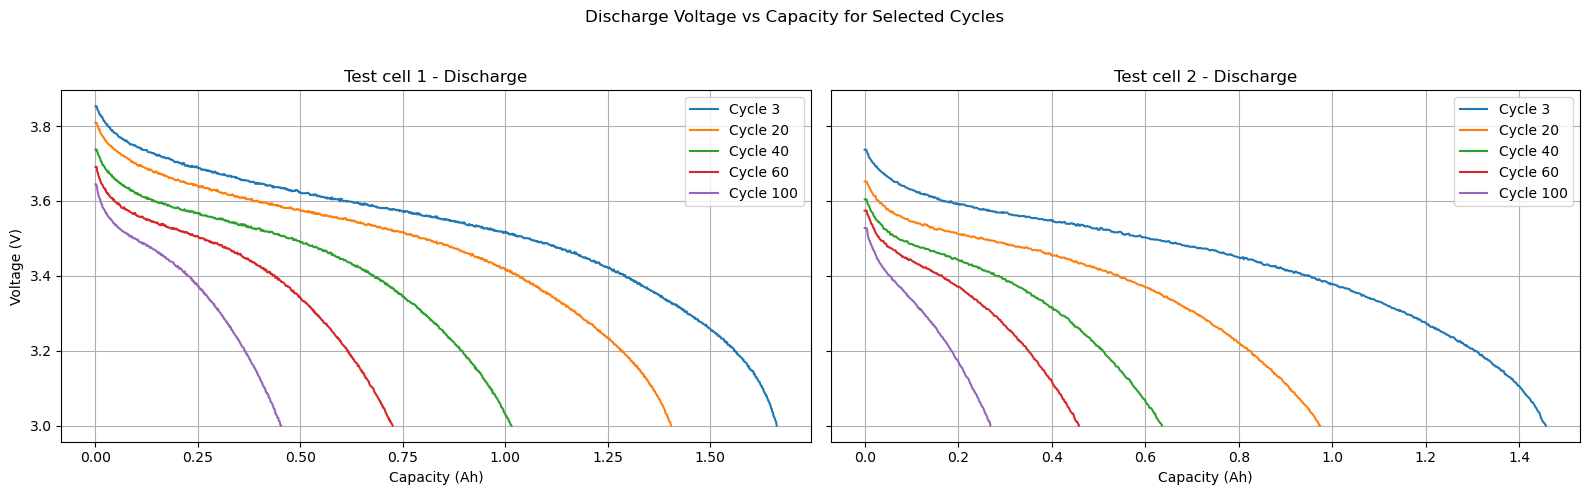

In [31]:

# No of cycles and phase for discharge
selected_cycles = [3, 20, 40, 60, 100]
phase = "discharge"

# Create subplots in a single row 
fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

# Ensure phase to  lowercase for consistent comparison
df_all["Phase"] = df_all["Phase"].str.lower()

# Loop through both test cells and plot discharge voltage vs capacity
for ax, cell in zip(axes, df_all["source"].unique()):
    for cycle in selected_cycles:
        # Filter data
        mask = (
            (df_all["source"] == cell) &
            (df_all["Cycle_Index"] == cycle) &
            (df_all["Phase"] == phase)
        )
        data = df_all[mask]

        if not data.empty:
            ax.plot(data["Capacity(Ah)"], data["Voltage(V)"], label=f"Cycle {cycle}")

    ax.set_title(f"{cell} - Discharge")
    ax.set_xlabel("Capacity (Ah)")
    ax.grid(True)
    ax.legend()

axes[0].set_ylabel("Voltage (V)")
plt.suptitle("Discharge Voltage vs Capacity for Selected Cycles")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Here if we consider cycle 3 , capacity on x-axis is the discharged Ah starting from 0 at full charge, and voltage (y-axis) drops from ~3.8 V down to ~3.0 V.On discharge, both cells shows a sloping voltage decline with a characteristic nominal platea around 3.6–3.7 V for much of the mid-capacity range. The Cell2 is lower in voltage at any given capacity than cell 1 curve.( may be  due to the higher IR drop at the larger current). Cell2 hits the low-voltage cutoff (around 3.0 V) after about 1.46 Ah is discharged, whereas Cell1 delivers ~1.66 Ah before reaching the cutoff. This shows a higher C rate produces a lower capacity reading. At second cell the usable capacity in that cycle is less. In summary, cell2 discharge not only started from a slightly lower charged state, but also suffers greater voltage low, leading to end early.

## Capacity vs Cycle Count Trends

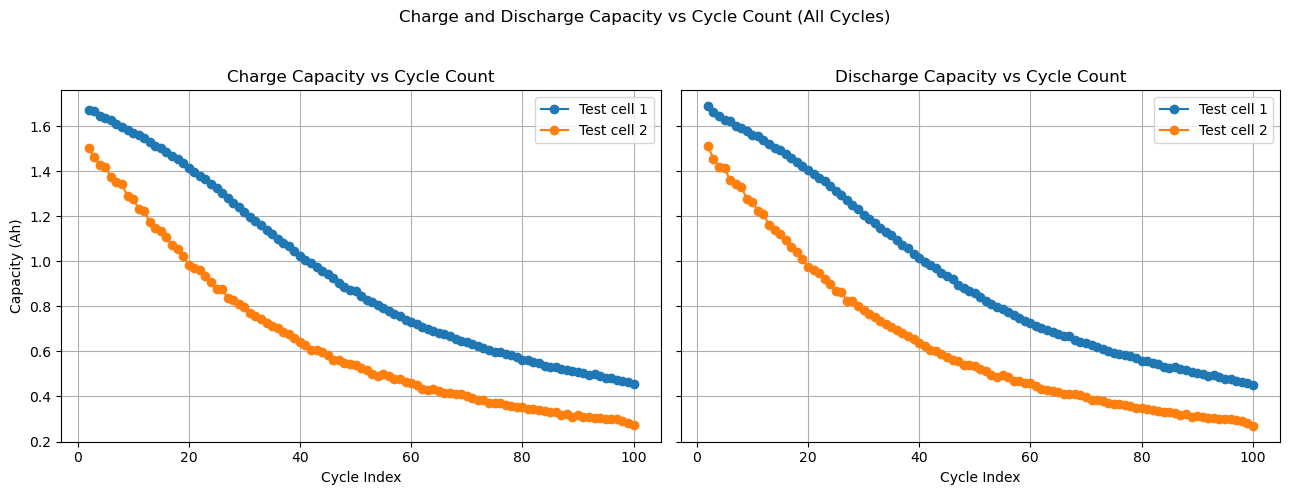

In [32]:
# Plot Charge and Discharge Capacity vs Cycle Count using all available data
fig, axes = plt.subplots(1, 2, figsize=(13, 5), sharey=True)

# Plot Charge Capacity
for cell in df_cycle["source"].unique():
    subset = df_cycle[df_cycle["source"] == cell]
    axes[0].plot(subset["Cycle_Index"], subset["charge_capacity_Ah"], marker='o', label=cell)

axes[0].set_title("Charge Capacity vs Cycle Count")
axes[0].set_xlabel("Cycle Index")
axes[0].set_ylabel("Capacity (Ah)")
axes[0].legend()
axes[0].grid(True)

# Plot Discharge Capacity
for cell in df_cycle["source"].unique():
    subset = df_cycle[df_cycle["source"] == cell]
    axes[1].plot(subset["Cycle_Index"], subset["discharge_capacity_Ah"], marker='o', label=cell)

axes[1].set_title("Discharge Capacity vs Cycle Count")
axes[1].set_xlabel("Cycle Index")
axes[1].legend()
axes[1].grid(True)

plt.suptitle("Charge and Discharge Capacity vs Cycle Count (All Cycles)")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In charge capacity, both cells start approximately 1.6–1.7 Ah charge capacity starts from Cycle 2. From there, the charge capacity drops as cycles progress. Cell1 declines from ~1.67 Ah to about 0.45 Ah by cycle 100. Cell2 starts at ~1.50 Ah and falls to about 0.27 Ah by cycle 100. The higher C-rate may cause the fade by cycle (50-50). Both curves are smoothly and gradually declining, though Cell2’s curve is more declining. 

In the discharge capacity plot,In Cycle 2 capacity drops from ~1.68 Ah for rest cell 1 and ~1.51 Ah for test cell 2.
After that, a more gradual decline can be seen. We see Cell1’s capacity decreasing from ~1.6 Ah at cycle 2 down to ~0.45 Ah at cycle 100. Cell2 declines from ~1.5 Ah to ~0.27 Ah by cycle 100. By cycle ~50, Cell1 have about ~0.9–1.0 Ah, while Cell2 is around ~0.6–0.7 Ah. So here The higher C-rate cell exhibits a faster capacity fade. In fact, by 100 cycles the test cell 2 has lost ~90% of its initial capacity, whereas the 2C cell lost ~80%. Both cells have effectively reached end-of-life criteria (often defined as 80% capacity loss) very quickly, but the 3C cell reached that threshold in fewer cycles.

## Effect of C-rate

Comparing the two cells, we can say the effect of the different C-rates 

1.Lower per-cycle capacity . At the higher current, each discharge delivered less energy and capacity than the lower current case, due to increased internal losses. Higher discharge rates cause lower measured capacity because not all the stored
charge can be utilized at high draw.

2.Faster degradation : -  High C rates increases the mechanical and chemical degradation. They cause more heat generation, higher mechanical strain on electrodes, and can also cause the side reactions (SEI growth, lithium plating during charging, etc.) can reduce capacity. 

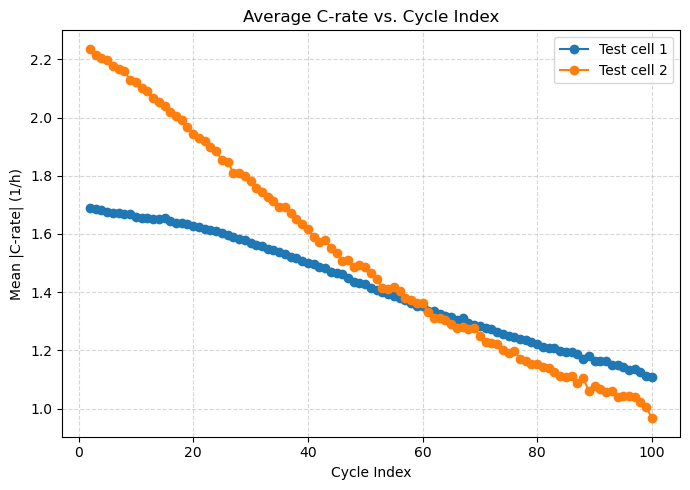

In [33]:
# Make c_rate_abs
if "c_rate_abs" not in df_all.columns:
    df_all["c_rate_abs"] = df_all["C-rate"].abs()

# Compute per‐cycle mean absolute C‐rate
cycle_cr = (
    df_all
      .groupby(['source', 'Cycle_Index'])['c_rate_abs']
      .mean()
      .reset_index(name='mean_c_rate')
)

# Plot
plt.figure(figsize=(7, 5))
for src, color in zip(cycle_cr['source'].unique(), ['tab:blue', 'tab:orange']):
    sub = cycle_cr[cycle_cr['source'] == src]
    plt.plot(sub['Cycle_Index'], sub['mean_c_rate'],
             marker='o', linestyle='-', color=color, label=src)

plt.xlabel('Cycle Index')
plt.ylabel('Mean |C-rate| (1/h)')
plt.title('Average C-rate vs. Cycle Index')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


During Constant Current (CC), the is current is fixed, so C-rate is high. Once the voltage limit is reached, CV mode comes in and current begins to change mean C-rate per cycle drops. As capacity fades over time, we begain to hit the voltage limit sooner and that increases the time of each cycle spent in CV. And thus lowering average C-rate further.The effect is more in Test Cell 2, consistent with its higher initial C-rate and more aggressive cycling.

## Capacity Fade Extrapolation with Machine Learning

To model and extrapolate the charge capacity degradation of two lithium-ion cells (Test cell 1 and Test cell 2) up to 100 cycles, I used two different approaches:

1. Polynomial Ridge Regression

2. Exponential Decay Fitting

For Polynomial Ridge Regression
1. Created a pipeline with:StandardScaler, PolynomialFeatures, Ridge – to regularize polynomial coefficients
2. used GridSearchCv to choose optimal polynomial degree and alpa
3. Trained the model on training set
4. Evaluated on test set


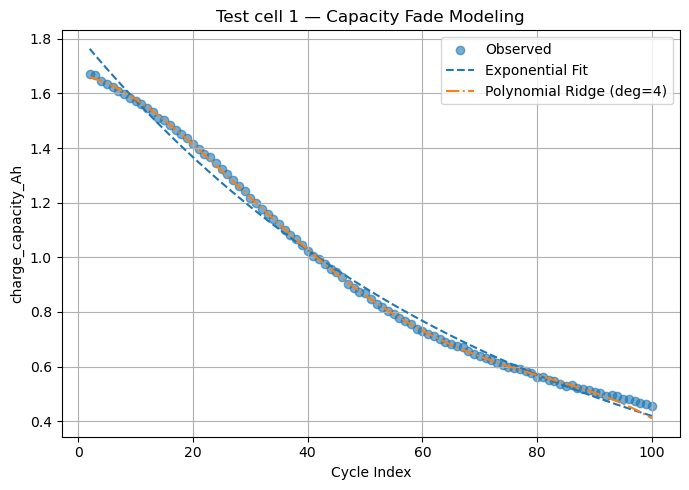

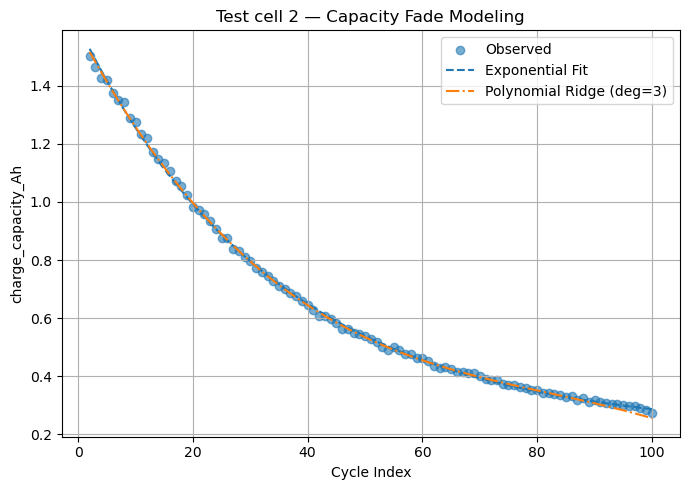

In [34]:
# Define exponential decay function
def exp_decay(x, A, B, C):
    return A * np.exp(-B * x) + C

# Store results
results = []

for src in ['Test cell 1', 'Test cell 2']:
    sub_df = df_cycle[df_cycle['source'] == src].copy()
    sub_df = sub_df[sub_df['Cycle_Index'] <= 100]

    # Split data
    train = sub_df[sub_df['Cycle_Index'] <= 80]
    test  = sub_df[sub_df['Cycle_Index'] >  80]

    X_train = train[['Cycle_Index']]
    y_train = train['charge_capacity_Ah']
    X_test  = test[['Cycle_Index']]
    y_test  = test['charge_capacity_Ah']

    # Polynomial Ridge Regression
    pipe = Pipeline([
        ('scale', StandardScaler()),
        ('poly',  PolynomialFeatures(include_bias=False)),
        ('ridge', Ridge())
    ])

    param_grid = {
        'poly__degree': [1, 2, 3, 4, 5, 6, 7],
        'ridge__alpha': np.linspace(0, 0.1, 21)
    }

    search = GridSearchCV(pipe, param_grid,
                          scoring='neg_root_mean_squared_error',
                          cv=4)
    search.fit(X_train, y_train)

    best = search.best_estimator_
    y_pred_test = best.predict(X_test)

    train_rmse = -search.best_score_
    test_rmse  = np.sqrt(mean_squared_error(y_test, y_pred_test))
    train_r2   = best.score(X_train, y_train)
    test_r2    = r2_score(y_test, y_pred_test)

    # Exponential fit to all 100 cycles
    x_full = sub_df['Cycle_Index'].values
    y_full = sub_df['charge_capacity_Ah'].values
    popt, _ = curve_fit(exp_decay, x_full, y_full, p0=[1.0, 0.01, 0.3])
    y_exp_pred = exp_decay(x_full, *popt)
    exp_rmse = np.sqrt(mean_squared_error(y_full, y_exp_pred))
    exp_r2 = r2_score(y_full, y_exp_pred)

    # Save results
    results.append({
        'source': src,
        'poly_degree': search.best_params_['poly__degree'],
        'ridge_alpha': search.best_params_['ridge__alpha'],
        'poly_train_RMSE': train_rmse,
        'poly_test_RMSE': test_rmse,
        'poly_train_R2': train_r2,
        'poly_test_R2': test_r2,
        'exp_A': popt[0],
        'exp_B': popt[1],
        'exp_C': popt[2],
        'exp_RMSE': exp_rmse,
        'exp_R2': exp_r2
    })

    # Plot results
    plt.figure(figsize=(7, 5))
    plt.scatter(x_full, y_full, label='Observed', alpha=0.6)
    plt.plot(x_full, y_exp_pred, label='Exponential Fit', linestyle='--')
    plt.plot(x_full, best.predict(pd.DataFrame(x_full, columns=['Cycle_Index'])), label=f'Polynomial Ridge (deg={search.best_params_["poly__degree"]})', linestyle='-.')
    plt.title(f'{src} — Capacity Fade Modeling')
    plt.xlabel('Cycle Index')
    plt.ylabel('charge_capacity_Ah')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [35]:
results

[{'source': 'Test cell 1',
  'poly_degree': 4,
  'ridge_alpha': 0.0,
  'poly_train_RMSE': 0.022562462941749288,
  'poly_test_RMSE': 0.019538272718405834,
  'poly_train_R2': 0.9998539093670579,
  'poly_test_R2': 0.5756577358617434,
  'exp_A': 1.874991946559719,
  'exp_B': 0.013597940407876992,
  'exp_C': -0.061638824292229714,
  'exp_RMSE': 0.031801863139095776,
  'exp_R2': 0.99327797541136},
 {'source': 'Test cell 2',
  'poly_degree': 3,
  'ridge_alpha': 0.1,
  'poly_train_RMSE': 0.016803371921500384,
  'poly_test_RMSE': 0.013529439031912475,
  'poly_train_R2': 0.9994638718558037,
  'poly_test_R2': 0.5194077779586747,
  'exp_A': 1.3964637594959726,
  'exp_B': 0.028905098708706504,
  'exp_C': 0.20936484928447968,
  'exp_RMSE': 0.008905982947103035,
  'exp_R2': 0.9993241397722925}]

Exponential Decay performs better for both cells in terms of R² and RMSE.
Polynomial Regression overfits slightly and generalizes poorly

### Polynomial extrapolation 

To model and extrapolate the charge capacity degradation trend of lithium-ion cells (Test cell 1 and Test cell 2) up to 150 cycles using Polynomial Ridge Regression, based on observed data from cycles 1–100.

1. Defined Target and Input
2. Preprocessing
3. Polynomial Feature Expansion
4. Ridge Regression Fitting
5. Extrapolation
6. Visualization

C:\Users\Thesna\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

C:\Users\Thesna\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names



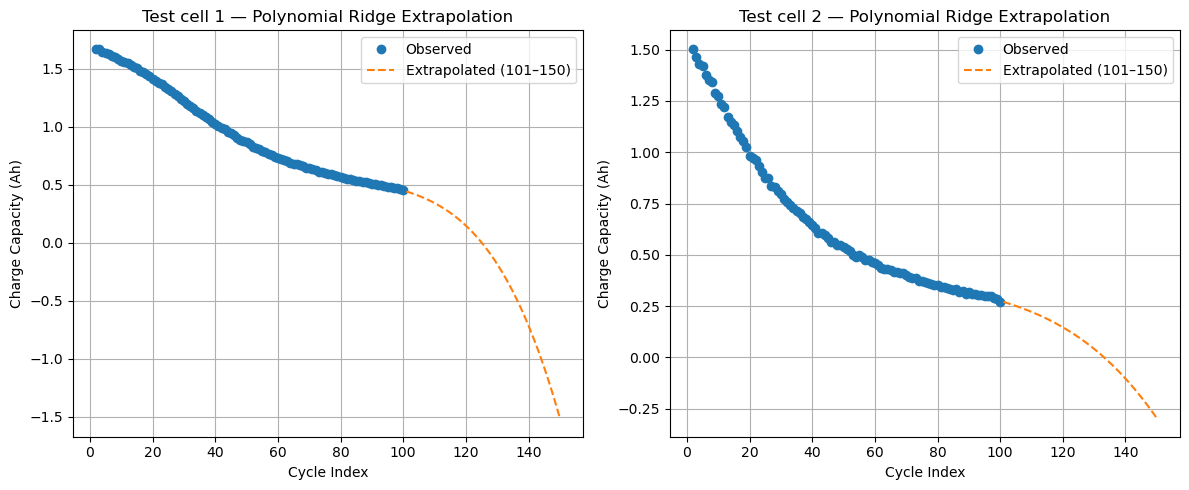

In [36]:
# Define extrapolation range
future_cycles = np.arange(101, 151).reshape(-1, 1)

# Polynomial model parameters from previous runs
poly_models = [
    {'source': 'Test cell 1', 'degree': 4, 'alpha': 0.0},
    {'source': 'Test cell 2', 'degree': 3, 'alpha': 0.1}
]

# Plot polynomial extrapolation
plt.figure(figsize=(12, 5))

for i, model_info in enumerate(poly_models, 1):
    src = model_info['source']
    degree = model_info['degree']
    alpha = model_info['alpha']

    sub_df = df_cycle[(df_cycle['source'] == src) & (df_cycle['Cycle_Index'] <= 100)]
    X_train = sub_df[['Cycle_Index']]
    y_train = sub_df['charge_capacity_Ah']

    # Fit polynomial ridge model
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_train)
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = poly.fit_transform(X_scaled)
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_poly, y_train)

    # Prepare future predictions
    X_future_scaled = scaler.transform(future_cycles)
    X_future_poly = poly.transform(X_future_scaled)
    y_future_pred = ridge.predict(X_future_poly)

    # Plot observed and extrapolated values
    plt.subplot(1, 2, i)
    plt.plot(X_train['Cycle_Index'], y_train, 'o', label='Observed')
    plt.plot(future_cycles, y_future_pred, '--', label='Extrapolated (101–150)')
    plt.title(f'{src} — Polynomial Ridge Extrapolation')
    plt.xlabel('Cycle Index')
    plt.ylabel('Charge Capacity (Ah)')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


### Exponential Decay

To model and extrapolate the charge capacity degradation of two lithium-ion cells Test cell 1 and Test cell 2 using an exponential decay model, and to predict capacity up to 150 cycles.

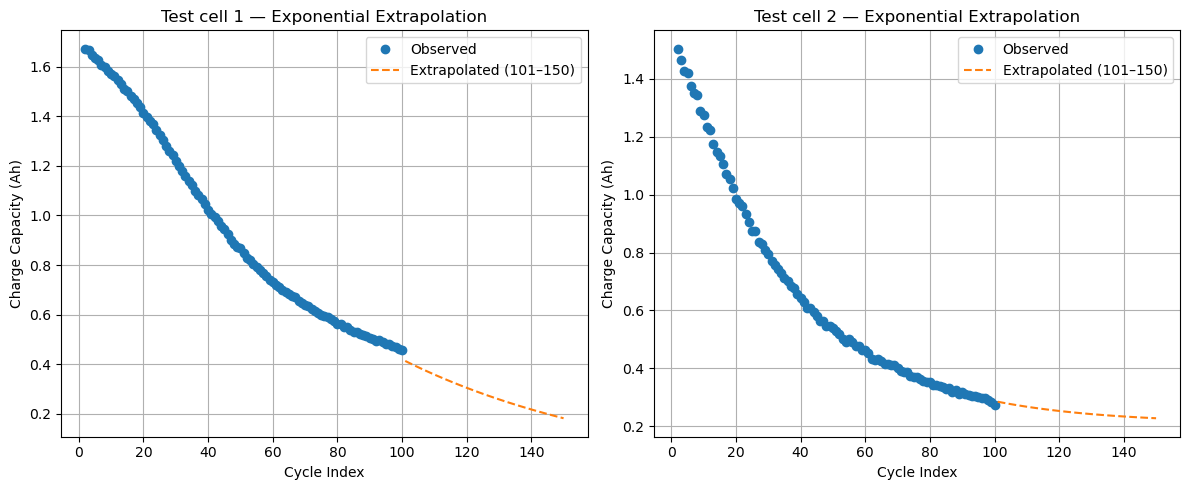

In [37]:
# Reuse the exponential decay function
def exp_decay(x, A, B, C):
    return A * np.exp(-B * x) + C

# Define extrapolation range
future_cycles = np.arange(101, 151)
plt.figure(figsize=(12, 5))

# Use known exponential parameters from previous fit
exp_params = [
    {'source': 'Test cell 1', 'A': 1.874991946559719, 'B': 0.013597940407876992, 'C': -0.061638824292229714},
    {'source': 'Test cell 2', 'A': 1.3964637594959726, 'B': 0.028905098708706504, 'C': 0.20936484928447968}
]

for i, params in enumerate(exp_params, 1):
    src = params['source']
    A, B, C = params['A'], params['B'], params['C']

    observed = df_cycle[(df_cycle['source'] == src) & (df_cycle['Cycle_Index'] <= 100)]
    x_obs = observed['Cycle_Index']
    y_obs = observed['charge_capacity_Ah']
    y_future = exp_decay(future_cycles, A, B, C)

    plt.subplot(1, 2, i)
    plt.plot(x_obs, y_obs, 'o', label='Observed')
    plt.plot(future_cycles, y_future, '--', label='Extrapolated (101–150)')
    plt.title(f'{src} — Exponential Extrapolation')
    plt.xlabel('Cycle Index')
    plt.ylabel('Charge Capacity (Ah)')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


If we go for a comparison between the two models polynomial ridge is good fit for training, sharp drop after 100 cycles and overfitting the tail. In case of exponential fit there is monotonically decreasing.Can be considered as battery degrading curve.

# SOH

##  State of Health (SoH) from the charge capacity of each cycle

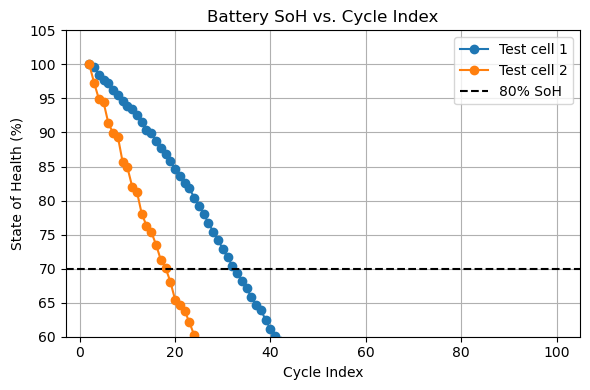

In [38]:
cycle_caps = df_cycle.rename(columns={'charge_capacity_Ah': 'Charge_Capacity_Ah'})
cycle_caps['SoH_%'] = (
    cycle_caps
    .groupby('source')['Charge_Capacity_Ah']
    .transform(lambda x: x / x.iloc[0] * 100)
)

plt.figure(figsize=(6, 4))
for src in cycle_caps['source'].unique():
    sub = cycle_caps[cycle_caps['source'] == src]
    plt.plot(sub['Cycle_Index'], sub['SoH_%'], marker='o', label=src)

plt.axhline(70, color='k', linestyle='--', label='80% SoH')
plt.xlabel('Cycle Index')
plt.ylabel('State of Health (%)')
plt.title('Battery SoH vs. Cycle Index')
plt.ylim(60, 105)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


The SOH definition is from the capacity perspective the ratio of the current maximum available capacity to the initial maximum capacity as the SOH evaluation index.Here its grouped by two cell as Test cell 1 and Test cell 2 separately.
Take the charge capacity at cycle 1 as the 100 % reference. Then divide every subsequent cycle’s capacity (x) by that initial capacity, then multiply by 100 to turn it into a percent.
The SOH is effected by the cycle number, Temperature and charge/ discharge rate. As the number of cycles increases, the SEI membrane continually grows, which raises the cell’s impedance and reduces its ability to store lithium and SOH reduces. Here temperature is 25°C. And high C rate cause SEI growth, graphite shedding, lithium plating, dendrite growth, and electrode-particle cracking, which together increase impedance and diminish both lithium capacity and active-material integrity.
Test cell 2 degrades faster, likely due to a higher C-rate.
These EOL cycle points where SOH is reducing to 80% is used for predicting Remaining Useful Life (RUL).

In [39]:
# function to find the first cycle where SoH drops below 80%
def cycle_to_threshold(df, thresh=80):
    sub = df.sort_values('Cycle_Index')
    # find two points bracketing 80% SoH
    above = sub[sub['SoH_%'] >= thresh]
    below = sub[sub['SoH_%'] <= thresh]
    if above.empty or below.empty:
        return None
    i1 = above['Cycle_Index'].max()
    i2 = below['Cycle_Index'].min()
    s1 = above.loc[above['Cycle_Index']==i1, 'SoH_%'].values[0]
    s2 = below.loc[below['Cycle_Index']==i2, 'SoH_%'].values[0]
    # linear interpolation
    return i1 + (thresh - s1) * (i2 - i1) / (s2 - s1)

for src in cycle_caps['source'].unique():
    sub = cycle_caps[cycle_caps['source']==src]
    life = cycle_to_threshold(sub, 80)
    print(f"{src} reaches 80% SoH at ~cycle {life:.1f}")


Test cell 1 reaches 80% SoH at ~cycle 24.4
Test cell 2 reaches 80% SoH at ~cycle 12.4


## State of Health (SoH) from the discharge charge capacity of each cycle

For most practical cases, for SOH analysis discharge capacity is used. Its mainly that what it measures is how much energy the battery delivers.

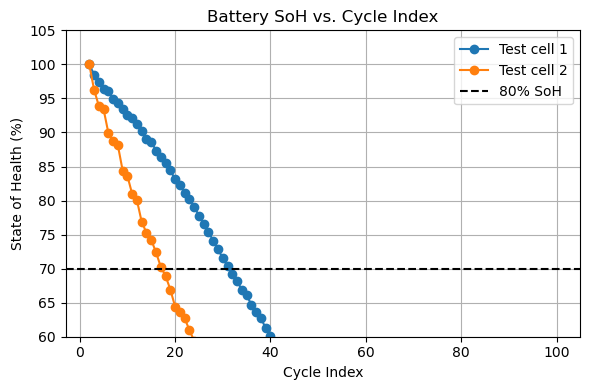

In [40]:
cycle_caps = df_cycle.rename(columns={'discharge_capacity_Ah': 'Discharge_Capacity_Ah'})
cycle_caps['SoH_%'] = (
    cycle_caps
    .groupby('source')['Discharge_Capacity_Ah']
    .transform(lambda x: x / x.iloc[0] * 100)
)

plt.figure(figsize=(6, 4))
for src in cycle_caps['source'].unique():
    sub = cycle_caps[cycle_caps['source'] == src]
    plt.plot(sub['Cycle_Index'], sub['SoH_%'], marker='o', label=src)

plt.axhline(70, color='k', linestyle='--', label='80% SoH')
plt.xlabel('Cycle Index')
plt.ylabel('State of Health (%)')
plt.title('Battery SoH vs. Cycle Index')
plt.ylim(60, 105)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [41]:
#function to find the first cycle where SoH drops below 80%
def cycle_to_threshold(df, thresh=80):
    sub = df.sort_values('Cycle_Index')
    # find two points bracketing 80% SoH
    above = sub[sub['SoH_%'] >= thresh]
    below = sub[sub['SoH_%'] <= thresh]
    if above.empty or below.empty:
        return None
    i1 = above['Cycle_Index'].max()
    i2 = below['Cycle_Index'].min()
    s1 = above.loc[above['Cycle_Index']==i1, 'SoH_%'].values[0]
    s2 = below.loc[below['Cycle_Index']==i2, 'SoH_%'].values[0]
    # linear interpolation
    return i1 + (thresh - s1) * (i2 - i1) / (s2 - s1)

for src in cycle_caps['source'].unique():
    sub = cycle_caps[cycle_caps['source']==src]
    life = cycle_to_threshold(sub, 80)
    print(f"{src} reaches 80% SoH at ~cycle {life:.1f}")


Test cell 1 reaches 80% SoH at ~cycle 23.3
Test cell 2 reaches 80% SoH at ~cycle 12.0
